In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import cv2
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary
from IPython.display import Audio
import IPython.display as ipd
import soundfile as sd
import padasip as dsp

/home/prasad/anaconda3/envs/aec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ICASSPDatasetHelper():
    #initialization 
    def __init__(self):
        self.sample_rate=8000
        fft_len=40
        hop_len=10
        self.dir= "./icassp_LUT.json"
        openfile=open(self.dir, "r")
        self.dataset_dict= json.load(openfile)
        indx=1
        self.keys={}
        for key  in self.dataset_dict.keys():
            self.keys[indx]=key
            indx+=1

        self.num_files_per_category=len(self.dataset_dict["echo_signal"].keys())

    #get the indexed file and sample rate
    def get_indxd_file(self,indx,src):
        category=self.keys[src]
        #load magnitude spectrum
        data=abs(np.load(self.dataset_dict[category][str(indx)]))
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

    #get the indexed file and sample rate
    def get_indxd_filestft(self,indx,src):
        category=self.keys[src]
        #load magnitude spectrum
        data=np.load(self.dataset_dict[category][str(indx)])
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

In [3]:
class ICASSP(Dataset):
    def __init__(self):
        #super().__init__(self)
        self.daps= ICASSPDatasetHelper()

    def __getitem__(self, index):
        mic,id=self.daps.get_indxd_file(index,2)
        fend,id=self.daps.get_indxd_file(index,3)
        nend,id=self.daps.get_indxd_file(index,4)
        return (mic,fend,nend)

    def __len__(self):
        
        #print (self.daps.num_files_per_category)
        return self.daps.num_files_per_category

In [4]:
dataset_train = ICASSP()
print(dataset_train.__len__())
print(dataset_train.daps.keys)

62000
{1: 'echo_signal', 2: 'nearend_mic_signal', 3: 'farend_speech', 4: 'nearend_speech'}


In [5]:
dtype = torch.float32 # we will be using float throughout this tutorial
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [7]:
NUM_TRAIN=30000
NUM_VAL=10000
NUM_TEST=5000
print_every = 100
dataset_train = ICASSP()
batch_size=4
loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN)))
loader_val= DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_TRAIN,NUM_VAL+NUM_TRAIN)))
loader_test = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.SequentialSampler(range(NUM_VAL+NUM_TRAIN, NUM_VAL+NUM_TRAIN+NUM_TEST)))

helper= ICASSPDatasetHelper()


In [8]:
print(dataset_train.daps.keys)

{1: 'echo_signal', 2: 'nearend_mic_signal', 3: 'farend_speech', 4: 'nearend_speech'}


In [9]:
#Create Model classes
# create a class for linear layers 
class DenseLayer(nn.Module):
    def __init__(self,input_size,output_size,dropOut_p):
        super().__init__()
        self.dense=nn.Linear(input_size,output_size,bias=True)
        self.activation=nn.Tanh()
        self.dropOut=nn.Dropout(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.dense(x)
        y=self.activation(y)
        y=self.dropOut(y)
        return y

#class for convolutional layers
class ConvLayer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size,stride,padding,dropOut_p):
        super().__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size, stride=stride,padding=padding)
        self.activation=nn.ReLU()
        self.dropOut=nn.Dropout2d(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.conv(x)
        y=self.activation(y)
        y=self.dropOut(y)

        return y

#RNN model for Residual echo suppression
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, fclayer_dim, output_dim, num_layers,dropout_prob):
        super().__init__()
        # Defining the number of layers and the nodes in each layer
        self.layer_dim=num_layers
        self.hidden_dim=hidden_dim
        self.rnn = nn.LSTM(
            fclayer_dim, hidden_dim, num_layers, batch_first=True
        )
        self.tanh=nn.Tanh()
        self.fc1= nn.Linear(input_dim,fclayer_dim)
        self.fc2= nn.Linear(hidden_dim,output_dim)
        self.sig=nn.Sigmoid()
        self.relu= nn.ReLU()


    def forward(self, x):
        
        y= self.fc1(x)

        y= self.tanh(y)
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, y.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(y)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out=self.tanh(out)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc2(out)
        out = self.sig(out)
        return out

In [10]:
#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_MSE(yhat,y,lossfn):
    target = torch.ones(1).to(device=device)
    #yhat=yhat.squeeze(0)
    #y=y.squeeze(0)
    #loss=lossfn(yhat,y,target)
    loss=lossfn(yhat,y)
    return loss

In [11]:
def check_accuracy(loader, model,lossfn):
    print('Checking accuracy on validation set')
    model.eval()  # set model to evaluation mode
    mse=0
    with torch.no_grad():
        for mic, fend, nend in loader:

            x=torch.concat((mic,fend),1)
            #print(x.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            mic=mic.to(device=device, dtype=dtype)
            nend=nend.to(device=device, dtype=dtype)
            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(nend, (0, 2, 1))
            mic=torch.permute(mic, (0, 2, 1))
            pw_x=x*x
            # Forward pass: compute scores and loss
            mask = model(pw_x)

            yhat= mask*mic
            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]
            mse+= Loss_MSE(y,yhat,lossfn)
        mse = mse / len(loader)
        print("Validation loss is", mse.cpu().numpy())
        return  mse.cpu().numpy()

In [12]:
print_every=1
def train_model(model, optimizer, scheduler ,epochs=1):
    """
    Train a model on DAPS.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: val loss and train loss
    """
    val_loss=[]
    train_loss=[]
    #lossfn=nn.CosineEmbeddingLoss(margin=0,reduction="mean")
    lossfn=nn.MSELoss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0
        for t, (mic, fend,nend) in enumerate(loader_train):
            
           
            x=torch.concat((mic,fend),1)
            #print(x.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            mic=mic.to(device=device, dtype=dtype)
            nend=nend.to(device=device, dtype=dtype)
            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(nend, (0, 2, 1))
            mic=torch.permute(mic, (0, 2, 1))
            pw_x=x*x
            # Forward pass: compute scores and loss

            mask = model(pw_x)
            #print(mask.shape)
            yhat= mask*mic

            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]

            loss = Loss_MSE(yhat, y, lossfn)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # Update parameters. We don't want to backpropagate through the
            running_loss += loss.item()
            

        if t % print_every == 0:
            print('Epoch %d, Iteration %d, loss = %.8f' % (e, t, (running_loss/len(loader_train))))
            train_loss.append(running_loss/len(loader_train))
            #check_accuracy_part2(loader_val, model_fn, params)
            
        vloss=check_accuracy(loader_val,model,lossfn)
        model.train()
        val_loss.append(vloss)
        scheduler.step(loss)
    return (train_loss,val_loss)

In [35]:
learning_rate = 1e-3
nfft_len=318
hop_size=nfft_len//4
specdims=(160,32)
model = LSTMNet(input_dim=specdims[0]*2, hidden_dim=25, fclayer_dim=25, output_dim=specdims[0], num_layers=1,dropout_prob=0.0)
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [36]:
batch_size = batch_size
summary(model, input_size=(batch_size,specdims[1], specdims[0]*2))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMNet                                  --                        --
├─Linear: 1-1                            [4, 32, 25]               8,025
├─Tanh: 1-2                              [4, 32, 25]               --
├─LSTM: 1-3                              [4, 32, 25]               5,200
├─Linear: 1-4                            --                        (recursive)
├─Tanh: 1-5                              [4, 32, 25]               --
├─ReLU: 1-6                              --                        --
├─Linear: 1-7                            [4, 32, 160]              4,160
├─Sigmoid: 1-8                           [4, 32, 160]              --
Total params: 17,385
Trainable params: 17,385
Non-trainable params: 0
Total mult-adds (M): 0.71
Input size (MB): 0.16
Forward/backward pass size (MB): 0.22
Params size (MB): 0.07
Estimated Total Size (MB): 0.45

In [15]:
(train_loss,val_loss)=train_model(model, optimizer, scheduler,200)

Epoch 0, Iteration 7499, loss = 0.55460774
Checking accuracy on validation set
Validation loss is 0.5414876
Epoch 1, Iteration 7499, loss = 0.50084228
Checking accuracy on validation set
Validation loss is 0.5084224
Epoch 2, Iteration 7499, loss = 0.48145158
Checking accuracy on validation set
Validation loss is 0.5000468
Epoch 3, Iteration 7499, loss = 0.47128861
Checking accuracy on validation set
Validation loss is 0.50180966
Epoch 4, Iteration 7499, loss = 0.46538350
Checking accuracy on validation set
Validation loss is 0.4787977
Epoch 5, Iteration 7499, loss = 0.45868076
Checking accuracy on validation set
Validation loss is 0.47315994
Epoch 6, Iteration 7499, loss = 0.45378864
Checking accuracy on validation set
Validation loss is 0.46576864
Epoch 7, Iteration 7499, loss = 0.44990538
Checking accuracy on validation set


KeyboardInterrupt: 

In [89]:
model_path= "./misc/aec_lstm_160_re.pth"
torch.save(model.state_dict(),model_path)

In [17]:
model_path= "./misc/aec_lstm_160_re.pth"
model=LSTMNet(input_dim=specdims[0]*2, hidden_dim=25, fclayer_dim=25, output_dim=specdims[0], num_layers=1,dropout_prob=0.0)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
dataset=ICASSPDatasetHelper()
#test_index=19485
#test_index=1970
test_index=28790
model.to(device="cpu")
mic,_= dataset.get_indxd_file(test_index,2)
fend,_= dataset.get_indxd_file(test_index,3)
nend,_= dataset.get_indxd_file(test_index,4)
echo,_= dataset.get_indxd_file(test_index,1)
mic = torch.tensor(mic)
fend = torch.tensor(fend)
nend = torch.tensor(nend)
y=torch.permute(nend,(1,0))
x=torch.concat((mic,fend),0)
x= torch.permute(x,(1,0))
x=x.unsqueeze(0)
x=x.to(dtype=torch.float32)
model.eval()
with torch.no_grad():
    out=model(x*x)
out = out *y
out=out.squeeze(0)
out= torch.permute(out,(1,0))

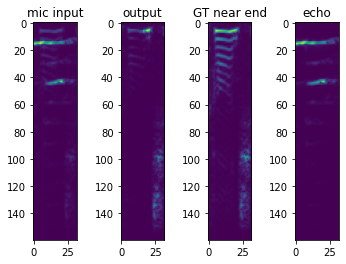

In [19]:
plt.figure()
plt.title("Comparison of echo cancellation output vs Ground Truth")
ax1=plt.subplot(1,4,1)
ax1.imshow(mic.numpy())
ax1.title.set_text("mic input")
ax2=plt.subplot(1,4,2)
ax2.imshow(out.cpu().numpy())
ax2.title.set_text("output")
ax3=plt.subplot(1,4,3)
ax3.imshow(nend.numpy())
ax3.title.set_text("GT near end")
ax4=plt.subplot(1,4,4)
ax4.imshow(echo)
ax4.title.set_text("echo")

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss","validation loss"])

Run a test file using the model to process and remove the echo

In [30]:
file_indx=12
mic_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_"+str(file_indx)+".wav",sr=8000)
fend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
nend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_"+str(file_indx)+".wav",sr=8000)


In [31]:
nfft_len=318
mic_stft=librosa.stft(mic_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
fend_stft=librosa.stft(fend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
nend_stft=librosa.stft(nend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)

In [32]:

fx=librosa.stft(fend_sig,n_fft=318,hop_length=318//4)
res_spec=np.zeros_like(fx)
for i in range(0,31):
    mic=  mic_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    fend= fend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    nend= nend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    tmic = torch.tensor(abs(mic))
    tfend = torch.tensor(abs(fend))
    tnend = torch.tensor(abs(nend))
    y=torch.permute(tnend,(1,0))
    x=torch.concat((tmic,tfend),0)
    x= torch.permute(x,(1,0))
    x=x.unsqueeze(0)
    x=x.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(x*x)
    out = out*y
    out=out.squeeze(0)
    out= torch.permute(out,(1,0))
    out=out.cpu().numpy()
    mag,ph=librosa.magphase(mic)
    out=out*ph
    #print(out.shape)
    res_spec[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out
    #specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec
res_nend=librosa.istft(res_spec,hop_length=nfft_len//4,n_fft=nfft_len)
#res_nend=librosa.util.normalize(res_nend)
print(res_nend.shape)

(79948,)


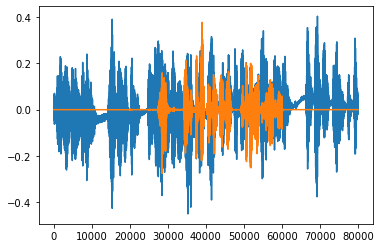

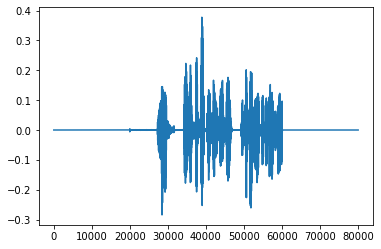

In [33]:
plt.figure()
plt.plot(mic_sig)
plt.plot(res_nend)
plt.figure()
plt.plot(nend_sig)


Dump processed files

In [34]:
wav.write("../op/echo_cancelled_fileid_"+str(file_indx)+".wav", 8000, res_nend)
wav.write("../op/mic_fileid_"+str(file_indx)+".wav", 8000, mic_sig)
wav.write("../op/nend_fileid_"+str(file_indx)+".wav", 8000, nend_sig)
wav.write("../op/fend_fileid_"+str(file_indx)+".wav", 8000, fend_sig)